In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
train = pd.read_csv(
    "assignment2_data/assignment_2_train.csv"
)
print("data.shape = {} rows, {} cols".format(*train.shape))
train.head(n=2)

data.shape = 9221 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
test_leadboard = pd.read_csv(
    "assignment2_data/assignment_2_test.csv"
)
print("data.shape = {} rows, {} cols".format(*test_leadboard.shape))
test_leadboard.head(n=2)

data.shape = 8676 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [4]:
# Анализ пропусков
import missingno as msno

<AxesSubplot:>

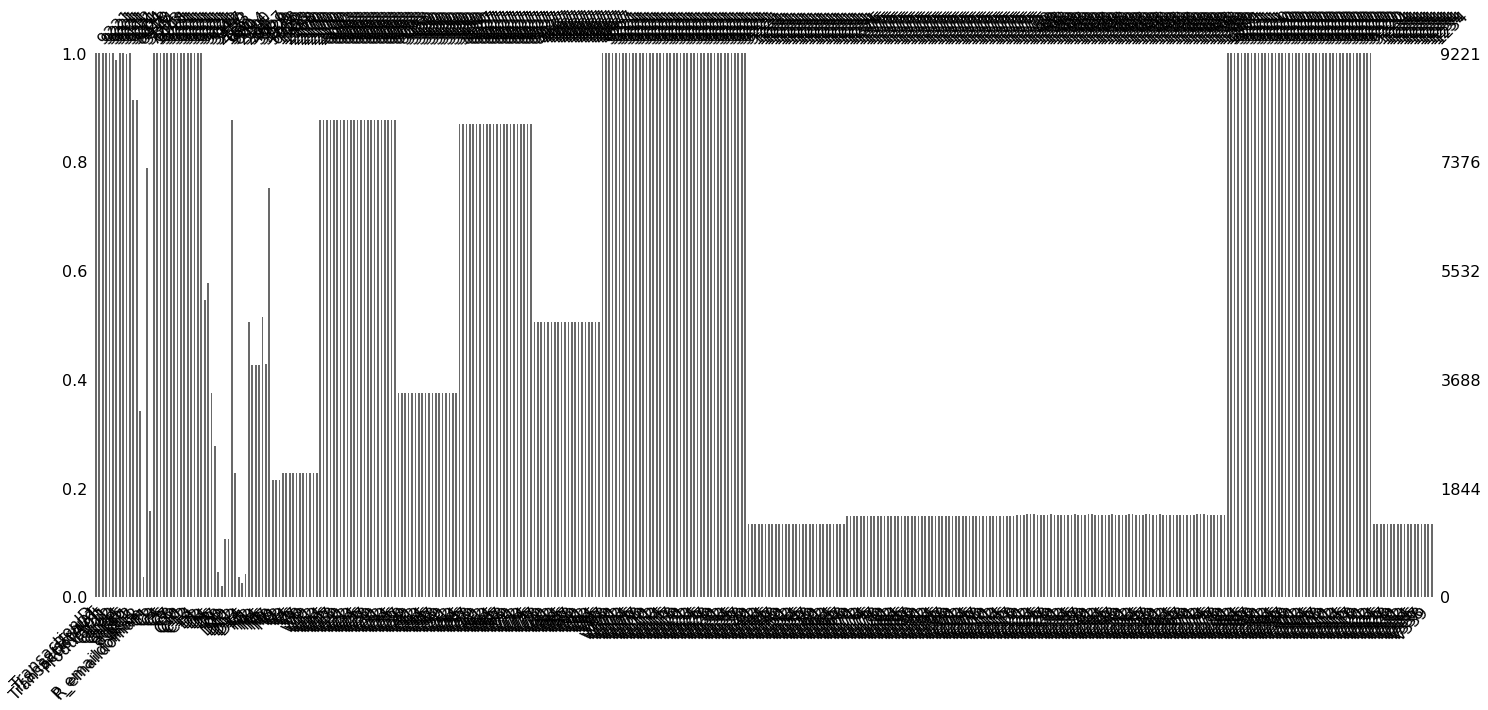

In [5]:
msno.bar(train, labels=True)

In [6]:
# Выберем те признаки, пропуски в которых менее 40%
features2 = [
    feature for feature in train.columns
    if (train[feature].isnull().sum() / train.shape[0]) < 0.4]

In [7]:
train = train[features2]
test_leadboard = test_leadboard[features2]

In [8]:
numerical_features = train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()
print(f"Categorical Feature Count {len(numerical_features)}")

Categorical Feature Count 157


In [9]:
# Категориальные признаки
categorical_features = train.select_dtypes(include=[np.object])
categorical_features = categorical_features.columns.tolist()
print(f"Categorical Feature Count {len(categorical_features)}")

Categorical Feature Count 5


In [10]:
train = train[numerical_features]
test_leadboard = test_leadboard[numerical_features]

In [11]:
x_train, x_valid = train_test_split(
    train.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.75, shuffle=True, random_state=1,
)

In [12]:
import catboost as cb

In [13]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5849173	test1: 0.5871125	best: 0.5871125 (0)	total: 157ms	remaining: 31.2s
10:	test: 0.7547694	test1: 0.7498850	best: 0.7498850 (10)	total: 226ms	remaining: 3.88s
20:	test: 0.7615413	test1: 0.7674568	best: 0.7674568 (20)	total: 274ms	remaining: 2.33s
30:	test: 0.7776376	test1: 0.7860752	best: 0.7860752 (30)	total: 320ms	remaining: 1.75s
40:	test: 0.7927978	test1: 0.7986375	best: 0.7986375 (40)	total: 371ms	remaining: 1.44s
50:	test: 0.8004116	test1: 0.7978375	best: 0.7995707 (45)	total: 423ms	remaining: 1.24s
60:	test: 0.8057681	test1: 0.7974142	best: 0.7995707 (45)	total: 470ms	remaining: 1.07s
70:	test: 0.8145396	test1: 0.8042303	best: 0.8042303 (70)	total: 518ms	remaining: 941ms
80:	test: 0.8241437	test1: 0.8150660	best: 0.8150660 (80)	total: 565ms	remaining: 830ms
90:	test: 0.8279996	test1: 0.8182458	best: 0.8182458 (90)	total: 617ms	remaining: 739ms
100:	test: 0.8346096	test1: 0.8172858	best: 0.8182458 (90)	total: 667ms	remaining: 653ms
110:	test: 0.8356609	test1: 0.819

In [14]:
val = roc_auc_score(y_valid, \
              model.predict(x_valid)
             )
print(f'RocAUC на валидационной выборке {val}')

RocAUC на валидационной выборке 0.589328924826515


In [15]:
lead = roc_auc_score(test_leadboard['isFraud'], \
              model.predict(
                  test_leadboard.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
             )
print(f'RocAUC на leaderboard {lead}')

RocAUC на leaderboard 0.5117994100294985


### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [16]:
x_train, x_valid = train_test_split(
    train.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.75, shuffle=True, random_state=1,
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.65, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.65, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 6915 rows, 154 cols
x_valid.shape = 1498 rows, 154 cols
x_test.shape = 808 rows, 154 cols


In [17]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5849173	test1: 0.5677410	best: 0.5677410 (0)	total: 5.81ms	remaining: 1.16s
10:	test: 0.7547694	test1: 0.7065427	best: 0.7065427 (10)	total: 59.2ms	remaining: 1.02s
20:	test: 0.7615413	test1: 0.7163789	best: 0.7163789 (20)	total: 113ms	remaining: 966ms
30:	test: 0.7776376	test1: 0.7404173	best: 0.7404173 (30)	total: 182ms	remaining: 990ms
40:	test: 0.7927978	test1: 0.7528372	best: 0.7528372 (40)	total: 246ms	remaining: 953ms
50:	test: 0.8004116	test1: 0.7546442	best: 0.7546442 (50)	total: 298ms	remaining: 870ms
60:	test: 0.8057681	test1: 0.7553310	best: 0.7553310 (60)	total: 349ms	remaining: 795ms
70:	test: 0.8145396	test1: 0.7624444	best: 0.7624444 (70)	total: 397ms	remaining: 721ms
80:	test: 0.8241437	test1: 0.7722887	best: 0.7722887 (80)	total: 443ms	remaining: 651ms
90:	test: 0.8279996	test1: 0.7762297	best: 0.7770964 (88)	total: 493ms	remaining: 590ms
100:	test: 0.8346096	test1: 0.7775870	best: 0.7775870 (100)	total: 546ms	remaining: 535ms
110:	test: 0.8356609	test1: 0.

In [18]:
val = roc_auc_score(y_valid, model.predict(x_valid))
print(f'RocAUC на валидационной выборке {val}')

RocAUC на валидационной выборке 0.5829899267399268


In [19]:
test = roc_auc_score(y_test, model.predict(x_test))
print(f'RocAUC на валидационной выборке {test}')

RocAUC на валидационной выборке 0.6


In [20]:
lead = roc_auc_score(test_leadboard['isFraud'], \
              model.predict(
                  test_leadboard.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
             )
print(f'RocAUC на leaderboard {lead}')

RocAUC на leaderboard 0.5117994100294985


Вывод: Значения метрики на лидерборде значительно хуже чем на валидации. Это может говорить о различиях в этих выборках и так же о плохом качестве модели

### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [21]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [22]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.5237824675324676, 0.7)

Text(0.5, 0, 'sample number')

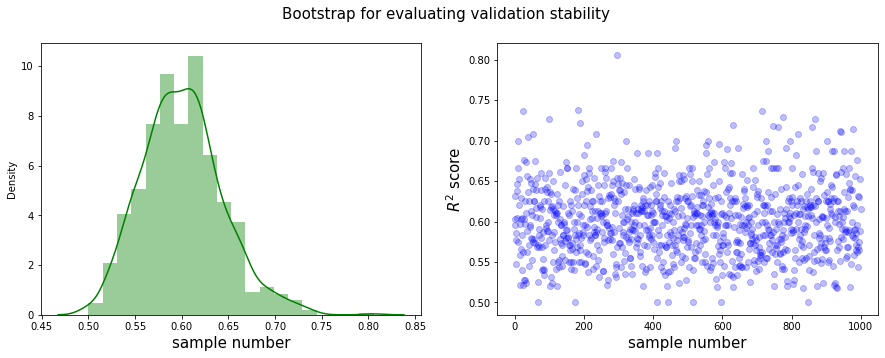

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

In [24]:
lead = roc_auc_score(test_leadboard['isFraud'], \
              model.predict(
                  test_leadboard.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
             )
print(f'RocAUC на leaderboard {lead}')

RocAUC на leaderboard 0.5117994100294985


Вывод: Метрика на лидерборд выборке не попадает в доверительный интервал, значит качество нашей модели неудовлетворительное. Нужно работать еще над моделью

### Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [25]:
x_adv = pd.concat([
    train.drop(["TransactionID", "TransactionDT"], axis=1), \
    test_leadboard.drop(["TransactionID", "TransactionDT"], axis=1)], axis=0
)
y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test_leadboard.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [26]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(x_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
y_pred_adv = model.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.9349


In [28]:
y_pred = model.predict_proba(train.drop(["TransactionID", "TransactionDT"], axis=1))
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    3648
(0.1, 0.2]    1808
(0.2, 0.3]     931
(0.3, 0.4]     681
(0.4, 0.5]     652
(0.5, 0.6]     421
(0.6, 0.7]     380
(0.7, 0.8]     484
(0.8, 0.9]     215
(0.9, 1.0]       1
dtype: int64

In [29]:
train['Adversarial'] = y_pred[:, 1]

In [30]:
train_val = train[train['Adversarial'] > 0.7]
train_tr = train[train['Adversarial'] <= 0.7]  

In [31]:
x_train = train_tr.drop(["TransactionID", "TransactionDT", "Adversarial", "isFraud"], axis=1)
y_train = train_tr["isFraud"]

x_valid = train_val.drop(["TransactionID", "TransactionDT", "Adversarial", "isFraud"], axis=1)
y_valid = train_val["isFraud"]

In [32]:
x_valid

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
1,29.00,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,59.00,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,49.00,5937,555.0,150.0,226.0,272.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,159.00,12308,360.0,150.0,166.0,126.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,422.50,12695,490.0,150.0,226.0,325.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9092,210.50,4272,111.0,150.0,226.0,299.0,87.0,1.0,2.0,0.0,...,0.0,0.000000,0.000000,0.000000,226.0,226.0,226.0,0.0,0.0,0.0
9098,34.00,12469,360.0,150.0,166.0,204.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9138,29.00,2755,404.0,150.0,102.0,269.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9181,108.95,1444,490.0,150.0,166.0,310.0,87.0,7.0,4.0,0.0,...,0.0,206.949997,206.949997,206.949997,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
cb_params = {
    "n_estimators": 300,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5978690	test1: 0.6947254	best: 0.6947254 (0)	total: 6.35ms	remaining: 1.9s
10:	test: 0.7063519	test1: 0.7991329	best: 0.8125000 (4)	total: 69.5ms	remaining: 1.82s
20:	test: 0.7544821	test1: 0.8117775	best: 0.8218931 (15)	total: 132ms	remaining: 1.75s
30:	test: 0.7814853	test1: 0.8045520	best: 0.8218931 (15)	total: 196ms	remaining: 1.7s
40:	test: 0.8061200	test1: 0.8298410	best: 0.8298410 (40)	total: 253ms	remaining: 1.6s
50:	test: 0.8140494	test1: 0.8223447	best: 0.8318280 (45)	total: 305ms	remaining: 1.49s
60:	test: 0.8177446	test1: 0.8185513	best: 0.8318280 (45)	total: 364ms	remaining: 1.42s
70:	test: 0.8231139	test1: 0.8161127	best: 0.8318280 (45)	total: 419ms	remaining: 1.35s
80:	test: 0.8248085	test1: 0.8150289	best: 0.8318280 (45)	total: 475ms	remaining: 1.28s
90:	test: 0.8265030	test1: 0.8235188	best: 0.8318280 (45)	total: 526ms	remaining: 1.21s
100:	test: 0.8288811	test1: 0.8252348	best: 0.8318280 (45)	total: 580ms	remaining: 1.14s
110:	test: 0.8300915	test1: 0.82496

In [34]:
val = roc_auc_score(y_valid, model.predict(x_valid))
print(f'RocAUC на валидационной выборке {val}')

RocAUC на валидационной выборке 0.5625


In [35]:
val = roc_auc_score(y_train, model.predict(x_train))
print(f'RocAUC на валидационной выборке {val}')

RocAUC на валидационной выборке 0.5533584679536171


In [36]:
lead = roc_auc_score(test_leadboard['isFraud'], \
              model.predict(
                  test_leadboard.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
             )
print(f'RocAUC на leaderboard {lead}')

RocAUC на leaderboard 0.5088495575221239


### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [37]:
cv = cross_val_score(
    estimator=model,
    X=train.drop(["TransactionID", "TransactionDT", "Adversarial", "isFraud"], axis=1),
    y=train["isFraud"],
    scoring="roc_auc",
    cv=10
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

0:	total: 6.01ms	remaining: 1.8s
10:	total: 60.2ms	remaining: 1.58s
20:	total: 103ms	remaining: 1.36s
30:	total: 151ms	remaining: 1.31s
40:	total: 195ms	remaining: 1.23s
50:	total: 243ms	remaining: 1.19s
60:	total: 292ms	remaining: 1.14s
70:	total: 346ms	remaining: 1.12s
80:	total: 421ms	remaining: 1.14s
90:	total: 516ms	remaining: 1.18s
100:	total: 587ms	remaining: 1.16s
110:	total: 668ms	remaining: 1.14s
120:	total: 724ms	remaining: 1.07s
130:	total: 793ms	remaining: 1.02s
140:	total: 845ms	remaining: 953ms
150:	total: 895ms	remaining: 884ms
160:	total: 967ms	remaining: 835ms
170:	total: 1.02s	remaining: 770ms
180:	total: 1.08s	remaining: 713ms
190:	total: 1.14s	remaining: 651ms
200:	total: 1.2s	remaining: 591ms
210:	total: 1.26s	remaining: 531ms
220:	total: 1.32s	remaining: 472ms
230:	total: 1.38s	remaining: 411ms
240:	total: 1.44s	remaining: 351ms
250:	total: 1.49s	remaining: 291ms
260:	total: 1.54s	remaining: 230ms
270:	total: 1.6s	remaining: 171ms
280:	total: 1.64s	remaining: 111

210:	total: 1.04s	remaining: 438ms
220:	total: 1.09s	remaining: 389ms
230:	total: 1.13s	remaining: 339ms
240:	total: 1.18s	remaining: 289ms
250:	total: 1.23s	remaining: 240ms
260:	total: 1.28s	remaining: 191ms
270:	total: 1.33s	remaining: 143ms
280:	total: 1.38s	remaining: 93.4ms
290:	total: 1.43s	remaining: 44.3ms
299:	total: 1.48s	remaining: 0us
0:	total: 5.46ms	remaining: 1.63s
10:	total: 57.7ms	remaining: 1.52s
20:	total: 102ms	remaining: 1.35s
30:	total: 148ms	remaining: 1.29s
40:	total: 197ms	remaining: 1.25s
50:	total: 257ms	remaining: 1.26s
60:	total: 326ms	remaining: 1.28s
70:	total: 391ms	remaining: 1.26s
80:	total: 440ms	remaining: 1.19s
90:	total: 492ms	remaining: 1.13s
100:	total: 541ms	remaining: 1.06s
110:	total: 590ms	remaining: 1s
120:	total: 638ms	remaining: 943ms
130:	total: 694ms	remaining: 895ms
140:	total: 747ms	remaining: 842ms
150:	total: 792ms	remaining: 782ms
160:	total: 840ms	remaining: 726ms
170:	total: 887ms	remaining: 670ms
180:	total: 934ms	remaining: 614

In [38]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [39]:
# Валидация на трейне
cv_strategy = KFold(n_splits=10, random_state=2)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train.drop(["TransactionID", "TransactionDT", "Adversarial", "isFraud"], axis=1), 
    train["isFraud"], model, metric=roc_auc_score, cv_strategy=cv_strategy
)

0:	total: 5.42ms	remaining: 1.62s
10:	total: 53.4ms	remaining: 1.4s
20:	total: 97.4ms	remaining: 1.29s
30:	total: 145ms	remaining: 1.25s
40:	total: 194ms	remaining: 1.23s
50:	total: 245ms	remaining: 1.19s
60:	total: 291ms	remaining: 1.14s
70:	total: 349ms	remaining: 1.12s
80:	total: 398ms	remaining: 1.07s
90:	total: 448ms	remaining: 1.03s
100:	total: 495ms	remaining: 976ms
110:	total: 546ms	remaining: 930ms
120:	total: 593ms	remaining: 878ms
130:	total: 650ms	remaining: 838ms
140:	total: 700ms	remaining: 789ms
150:	total: 747ms	remaining: 737ms
160:	total: 797ms	remaining: 688ms
170:	total: 845ms	remaining: 637ms
180:	total: 895ms	remaining: 589ms
190:	total: 941ms	remaining: 537ms
200:	total: 990ms	remaining: 488ms
210:	total: 1.04s	remaining: 439ms
220:	total: 1.08s	remaining: 388ms
230:	total: 1.13s	remaining: 338ms
240:	total: 1.18s	remaining: 289ms
250:	total: 1.23s	remaining: 240ms
260:	total: 1.27s	remaining: 190ms
270:	total: 1.32s	remaining: 141ms
280:	total: 1.37s	remaining: 

220:	total: 1.14s	remaining: 408ms
230:	total: 1.2s	remaining: 359ms
240:	total: 1.26s	remaining: 310ms
250:	total: 1.34s	remaining: 263ms
260:	total: 1.4s	remaining: 209ms
270:	total: 1.44s	remaining: 155ms
280:	total: 1.49s	remaining: 101ms
290:	total: 1.54s	remaining: 47.6ms
299:	total: 1.58s	remaining: 0us
Fold: 7, train-observations = 8299, valid-observations = 922
train-score = 0.5759, valid-score = 0.5915
0:	total: 5.12ms	remaining: 1.53s
10:	total: 51.8ms	remaining: 1.36s
20:	total: 96.2ms	remaining: 1.28s
30:	total: 142ms	remaining: 1.23s
40:	total: 189ms	remaining: 1.19s
50:	total: 233ms	remaining: 1.14s
60:	total: 282ms	remaining: 1.1s
70:	total: 329ms	remaining: 1.06s
80:	total: 379ms	remaining: 1.02s
90:	total: 431ms	remaining: 989ms
100:	total: 479ms	remaining: 943ms
110:	total: 526ms	remaining: 895ms
120:	total: 572ms	remaining: 847ms
130:	total: 619ms	remaining: 799ms
140:	total: 668ms	remaining: 753ms
150:	total: 714ms	remaining: 704ms
160:	total: 760ms	remaining: 656m

In [40]:
fold_valid_scores

[0.5,
 0.52,
 0.5294117647058824,
 0.5368113734450368,
 0.5769230769230769,
 0.6071428571428571,
 0.5915396522981662,
 0.625,
 0.6428571428571428,
 0.5810810810810811]

In [41]:
# Валидация на leaderboard
cv_strategy = KFold(n_splits=10, random_state=2)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    test_leadboard.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), 
    test_leadboard["isFraud"], model, metric=roc_auc_score, cv_strategy=cv_strategy
)

0:	total: 4.96ms	remaining: 1.48s
10:	total: 50.9ms	remaining: 1.34s
20:	total: 92.3ms	remaining: 1.23s
30:	total: 134ms	remaining: 1.16s
40:	total: 177ms	remaining: 1.12s
50:	total: 221ms	remaining: 1.08s
60:	total: 267ms	remaining: 1.05s
70:	total: 313ms	remaining: 1.01s
80:	total: 356ms	remaining: 963ms
90:	total: 401ms	remaining: 920ms
100:	total: 446ms	remaining: 879ms
110:	total: 488ms	remaining: 832ms
120:	total: 530ms	remaining: 784ms
130:	total: 572ms	remaining: 738ms
140:	total: 612ms	remaining: 690ms
150:	total: 653ms	remaining: 644ms
160:	total: 695ms	remaining: 600ms
170:	total: 737ms	remaining: 556ms
180:	total: 781ms	remaining: 514ms
190:	total: 823ms	remaining: 470ms
200:	total: 864ms	remaining: 426ms
210:	total: 908ms	remaining: 383ms
220:	total: 952ms	remaining: 340ms
230:	total: 994ms	remaining: 297ms
240:	total: 1.03s	remaining: 254ms
250:	total: 1.08s	remaining: 210ms
260:	total: 1.12s	remaining: 168ms
270:	total: 1.17s	remaining: 125ms
280:	total: 1.21s	remaining:

240:	total: 1.05s	remaining: 258ms
250:	total: 1.1s	remaining: 215ms
260:	total: 1.14s	remaining: 171ms
270:	total: 1.19s	remaining: 127ms
280:	total: 1.23s	remaining: 83ms
290:	total: 1.27s	remaining: 39.4ms
299:	total: 1.31s	remaining: 0us
Fold: 7, train-observations = 7809, valid-observations = 867
train-score = 0.6661, valid-score = 0.5469
0:	total: 7.76ms	remaining: 2.32s
10:	total: 56.8ms	remaining: 1.49s
20:	total: 98.1ms	remaining: 1.3s
30:	total: 140ms	remaining: 1.22s
40:	total: 182ms	remaining: 1.15s
50:	total: 226ms	remaining: 1.1s
60:	total: 270ms	remaining: 1.06s
70:	total: 315ms	remaining: 1.01s
80:	total: 358ms	remaining: 967ms
90:	total: 401ms	remaining: 922ms
100:	total: 447ms	remaining: 881ms
110:	total: 491ms	remaining: 836ms
120:	total: 534ms	remaining: 790ms
130:	total: 577ms	remaining: 744ms
140:	total: 619ms	remaining: 698ms
150:	total: 662ms	remaining: 653ms
160:	total: 705ms	remaining: 608ms
170:	total: 747ms	remaining: 563ms
180:	total: 789ms	remaining: 519ms

In [42]:
fold_valid_scores

[0.5555555555555556,
 0.6694915254237288,
 0.5689655172413793,
 0.6923076923076923,
 0.6666666666666666,
 0.5809120258272801,
 0.546875,
 0.6118612157073695,
 0.5277777777777778,
 0.4994075829383886]

Выводы: KFold валидация показывает, что модель неузтойчивая. Большой разброс.

### Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

In [44]:
# train.sort_values(['TransactionID'])
train_idx = int(train.shape[0] * 0.75)
test_idx = train.shape[0] - int(train.shape[0] * 0.75)

In [45]:
x_train = train.loc[range(train_idx)].drop(["TransactionID", "TransactionDT", "Adversarial", "isFraud"], axis=1)
y_train = train.loc[range(train_idx)]['isFraud']

x_valid = train.loc[range(test_idx)].drop(["TransactionID", "TransactionDT", "Adversarial", "isFraud"], axis=1)
y_valid = train.loc[range(test_idx)]['isFraud']

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 6915 rows, 154 cols
x_valid.shape = 2306 rows, 154 cols


In [46]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5642568	test1: 0.5977312	best: 0.5977312 (0)	total: 6.22ms	remaining: 1.24s
10:	test: 0.7302636	test1: 0.7718482	best: 0.7718482 (10)	total: 67.8ms	remaining: 1.17s
20:	test: 0.7493049	test1: 0.7685959	best: 0.7718482 (10)	total: 128ms	remaining: 1.09s
30:	test: 0.7684194	test1: 0.7877500	best: 0.7896784 (28)	total: 186ms	remaining: 1.01s
40:	test: 0.7782990	test1: 0.8010500	best: 0.8015113 (37)	total: 238ms	remaining: 923ms
50:	test: 0.7886247	test1: 0.8105025	best: 0.8110145 (49)	total: 302ms	remaining: 882ms
60:	test: 0.8007182	test1: 0.8259337	best: 0.8259337 (60)	total: 353ms	remaining: 803ms
70:	test: 0.8119534	test1: 0.8362028	best: 0.8372453 (68)	total: 401ms	remaining: 728ms
80:	test: 0.8171724	test1: 0.8407514	best: 0.8413050 (78)	total: 450ms	remaining: 661ms
90:	test: 0.8214226	test1: 0.8438976	best: 0.8438976 (90)	total: 500ms	remaining: 599ms
100:	test: 0.8231207	test1: 0.8423568	best: 0.8447557 (94)	total: 548ms	remaining: 537ms
110:	test: 0.8250692	test1: 0.8

In [47]:
val = roc_auc_score(y_valid, \
              model.predict(x_valid)
             )
print(f'RocAUC на валидационной выборке {val}')

RocAUC на валидационной выборке 0.5208333333333334


In [48]:
lead = roc_auc_score(test_leadboard['isFraud'], \
              model.predict(
                  test_leadboard.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
             )
print(f'RocAUC на leaderboard {lead}')

RocAUC на leaderboard 0.5221238938053098


In [49]:
# Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.5172413793103449, 0.6666666666666666)

Выводы: Разбиение по времени дает чуть лучше результат, чем рандомное разбиение. Метрика на лидерборде попадает в доверительный интервал. Это значит, что модель похоже работает как на валидационных данных так и на лидерборде.